<a href="https://colab.research.google.com/github/thisishasan/bigdata_mod_b/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download the dataset
!wget -nc 'https://raw.githubusercontent.com/thisishasan/bigdata_mod_b/refs/heads/main/dataset_aquifers_fe.csv'

File ‘dataset_aquifers_fe.csv’ already there; not retrieving.



In [2]:
!pip install colorama

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [4]:
df = pd.read_csv("dataset_aquifers_fe.csv")
df.head()

,Mean_Rainfall,Mean_Temp,Actual_Depth,Actual_Volume,Actual_Hydrometry,Date
0,0.415556,6.6250,-6.08026,-8019.271158,-0.083056,1998-01-04
1,2.054444,6.0750,-6.06452,-7956.571285,-0.104167,1998-01-05
2,0.921111,9.0875,-6.15706,-7715.808854,0.011944,1998-01-06
3,0.878889,12.3250,-6.10774,-7731.378766,-0.008611,1998-01-07
4,0.908889,12.6500,-6.05310,-7812.676449,-0.072222,1998-01-08


In [5]:
# Simplify column names
df.columns = ['rainfall', 'temperature','depth_to_groundwater', 'drainage_volume', 'river_hydrometry', 'date']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,rainfall,temperature,depth_to_groundwater,drainage_volume,river_hydrometry,date
0,0.415556,6.6250,-6.08026,-8019.271158,-0.083056,1998-01-04
1,2.054444,6.0750,-6.06452,-7956.571285,-0.104167,1998-01-05
2,0.921111,9.0875,-6.15706,-7715.808854,0.011944,1998-01-06
3,0.878889,12.3250,-6.10774,-7731.378766,-0.008611,1998-01-07
4,0.908889,12.6500,-6.05310,-7812.676449,-0.072222,1998-01-08


Since this is a TimeSeries problem, we have to parse 'date' column

In [6]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,rainfall,temperature,depth_to_groundwater,drainage_volume,river_hydrometry,date
0,0.415556,6.625000,-6.080260,-8019.271158,-0.083056,1998-01-04 00:00:00
1,2.054444,6.075000,-6.064520,-7956.571285,-0.104167,1998-01-05 00:00:00
2,0.921111,9.087500,-6.157060,-7715.808854,0.011944,1998-01-06 00:00:00
3,0.878889,12.325000,-6.107740,-7731.378766,-0.008611,1998-01-07 00:00:00
4,0.908889,12.650000,-6.053100,-7812.676449,-0.072222,1998-01-08 00:00:00


In [7]:
#Select sample of records (between full calendar years 2014 to 2018)
df = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2018-12-31')]
display(df)

,rainfall,temperature,depth_to_groundwater,drainage_volume,river_hydrometry,date
5781,0.008333,4.847500,-31.794369,-8383.569915,1.3450,2014-01-01
5782,6.585278,8.997500,-31.477058,-8367.562491,1.4400,2014-01-02
5783,27.550000,6.403750,-31.191011,-8377.114912,1.4375,2014-01-03
5784,0.028056,10.290000,-31.719530,-8694.318822,1.3475,2014-01-04
5785,1.998056,11.569375,-31.642628,-8924.585165,1.7950,2014-01-05
...,...,...,...,...,...,...
7602,0.050000,7.845556,-33.799024,-8511.901063,1.0750,2018-12-27
7603,0.050000,8.164306,-32.810362,-8464.556938,1.0750,2018-12-28
7604,0.055000,8.946806,-33.914981,-7875.646250,1.0725,2018-12-29
7605,0.054167,10.440278,-33.870962,-7463.417529,1.0725,2018-12-30


## Data visualization

Features:
* **Rainfall** indicates the quantity of rain falling (mm)
* **Temperature** indicates the temperature (°C)
* **Volume** indicates the volume of water taken from the drinking water treatment plant (m 3 )
* **Hydrometry** indicates the groundwater level (m)

Target:
* **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

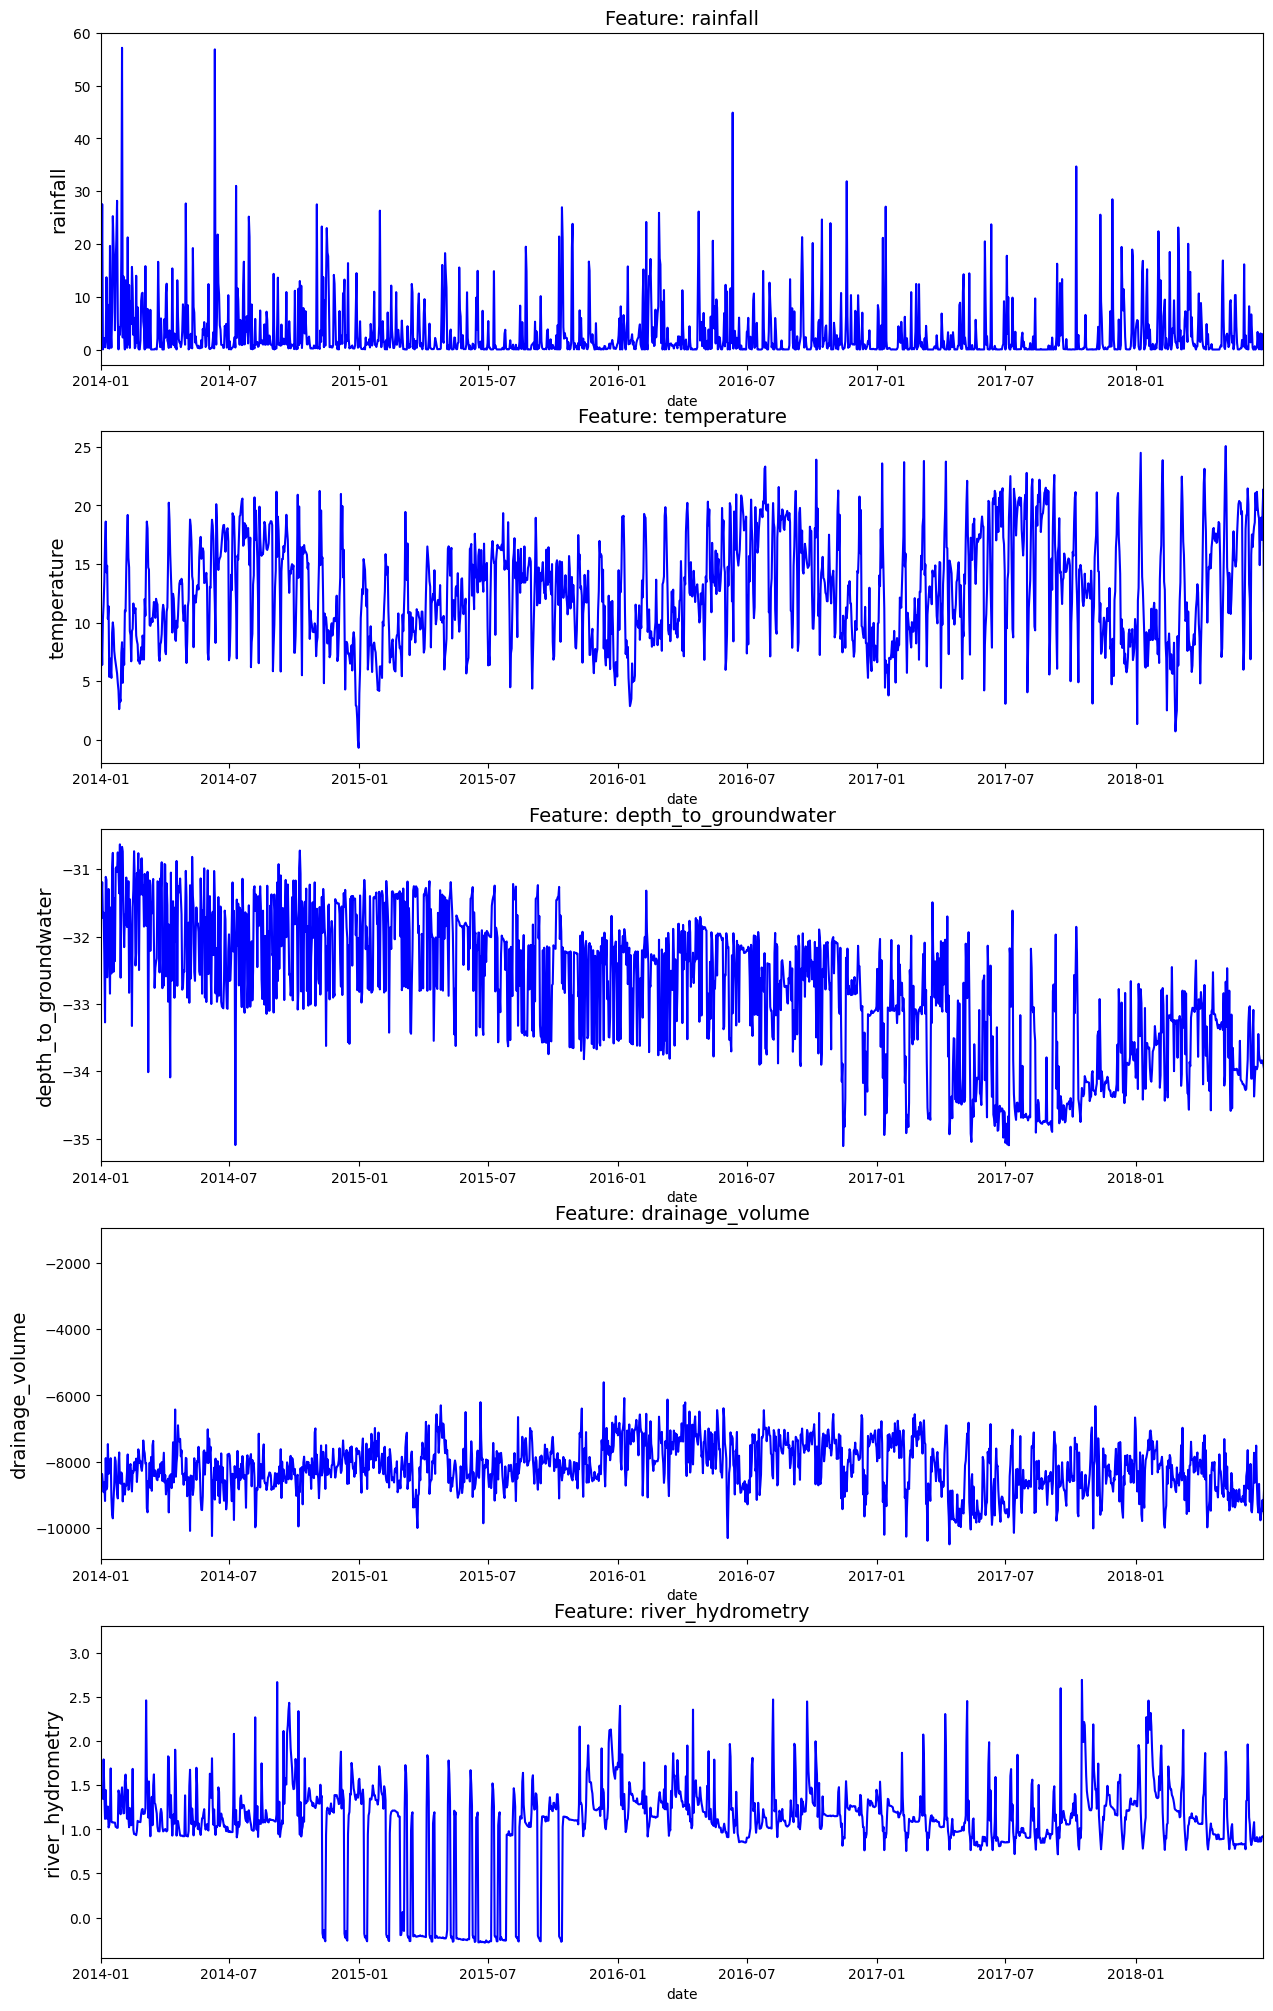

In [8]:
start_date = date(2014, 1, 1)
end_date = date(2018, 6, 30)
between_dates = [start_date, end_date]

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i], color='blue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

    ax[i].set_xlim(between_dates)

## Data Preprocessing

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [9]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
5781,2014-01-01,NaT
5782,2014-01-02,1 days
5783,2014-01-03,1 days
5784,2014-01-04,1 days
5785,2014-01-05,1 days


In [10]:
df['delta'].sum(), df['delta'].count()

(Timedelta('1825 days 00:00:00'), 1825)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

### Check Missing Values

In [11]:
df = df.drop('delta', axis=1)
df.isna().sum()

,0
rainfall,0
temperature,0
depth_to_groundwater,0
drainage_volume,0
river_hydrometry,0
date,0


We don't have missing values in the dataset.

### Smoothing data / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

* **Upsampling** is when the frequency of samples is increased (e.g. days to hours)
* **Downsampling** is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

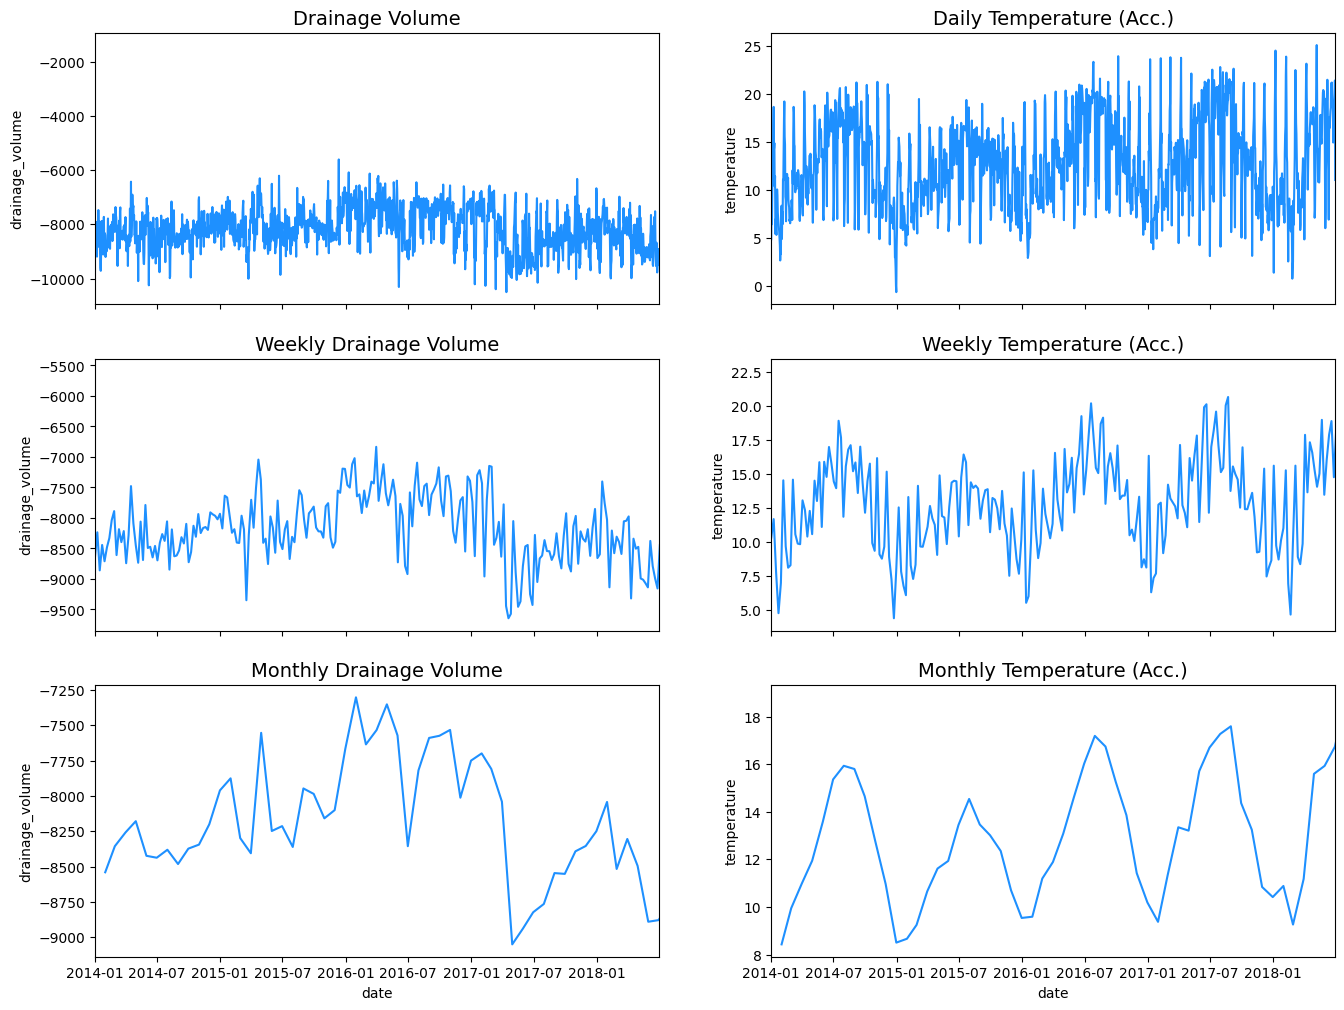

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim(between_dates)

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim(between_dates)
plt.show()

In [13]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'depth_to_groundwater',
                 'temperature',
                 'drainage_volume',
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

### Stationarity

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

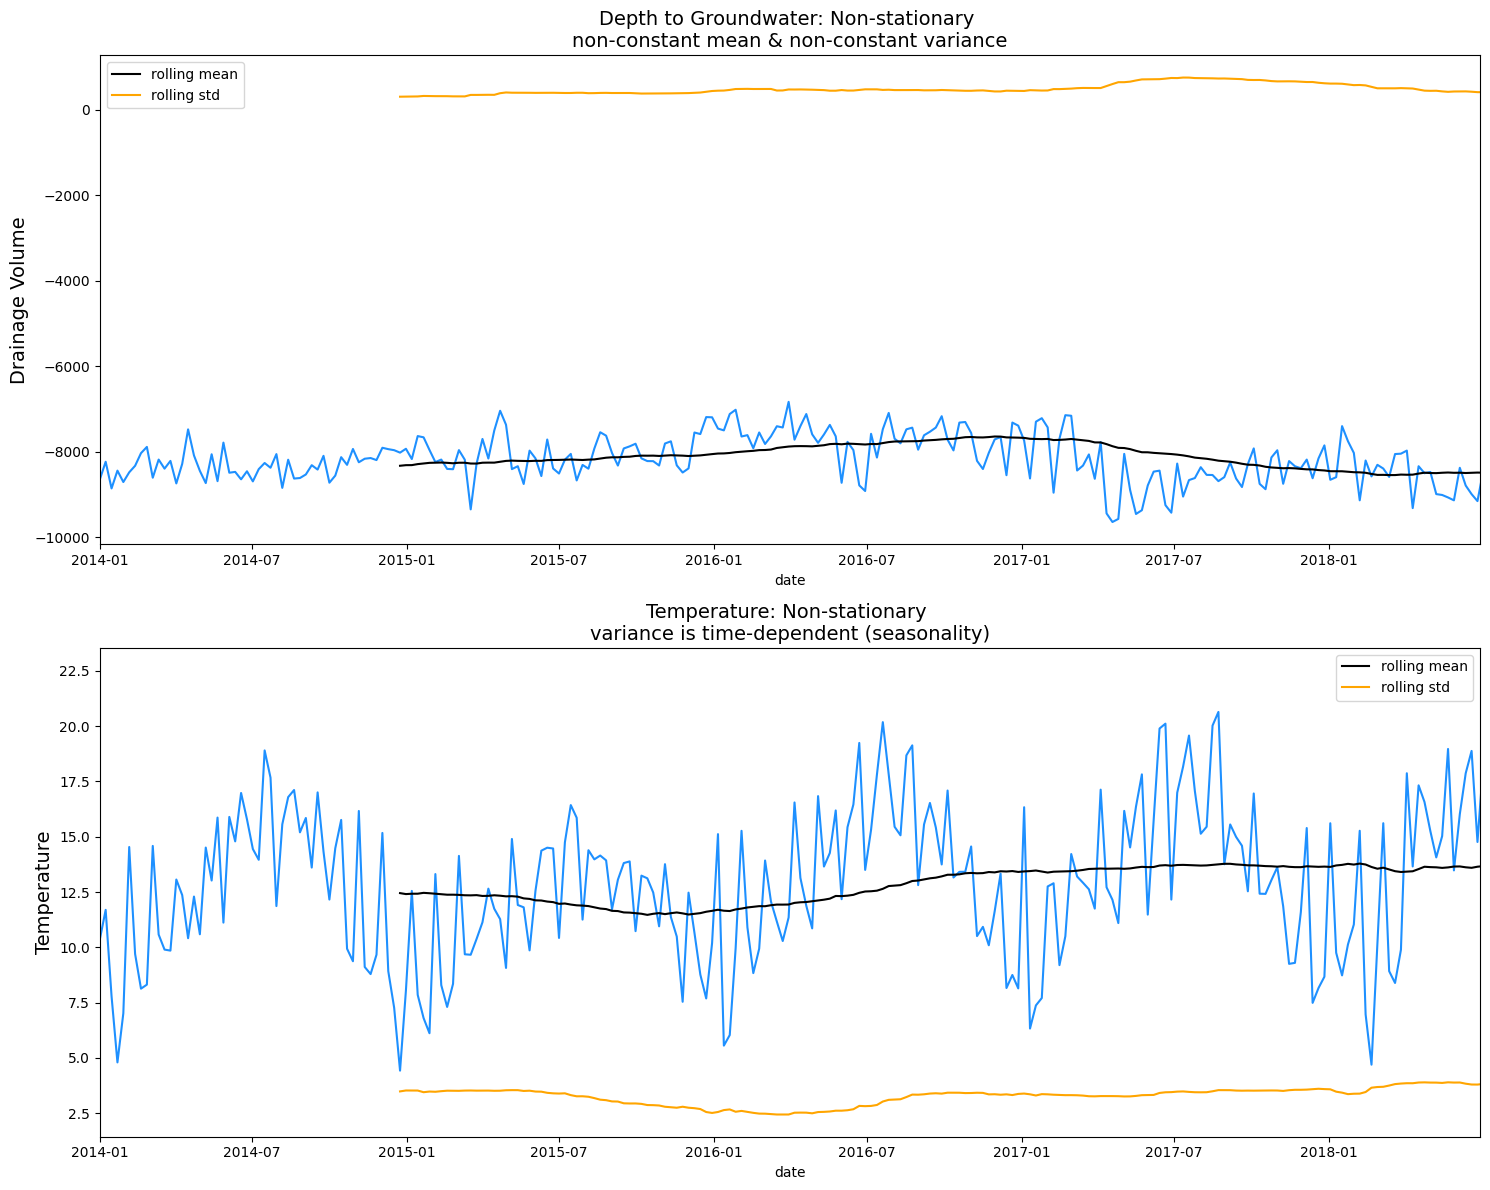

In [14]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim(between_dates)

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim(between_dates)

plt.tight_layout()
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

#### Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t = 	\alpha Y_{t-1} + 	\beta X_{e} + \epsilon $

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

**The presence of a unit root means the time series is non-stationary.**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.1 Augmented Dickey-Fuller (ADF)</p>


**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [15]:
# Install statsmodels
!pip install statsmodels

In [16]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-1.1388592631659067,
 0.6993292250472303,
 13,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 177.66908581627024)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values

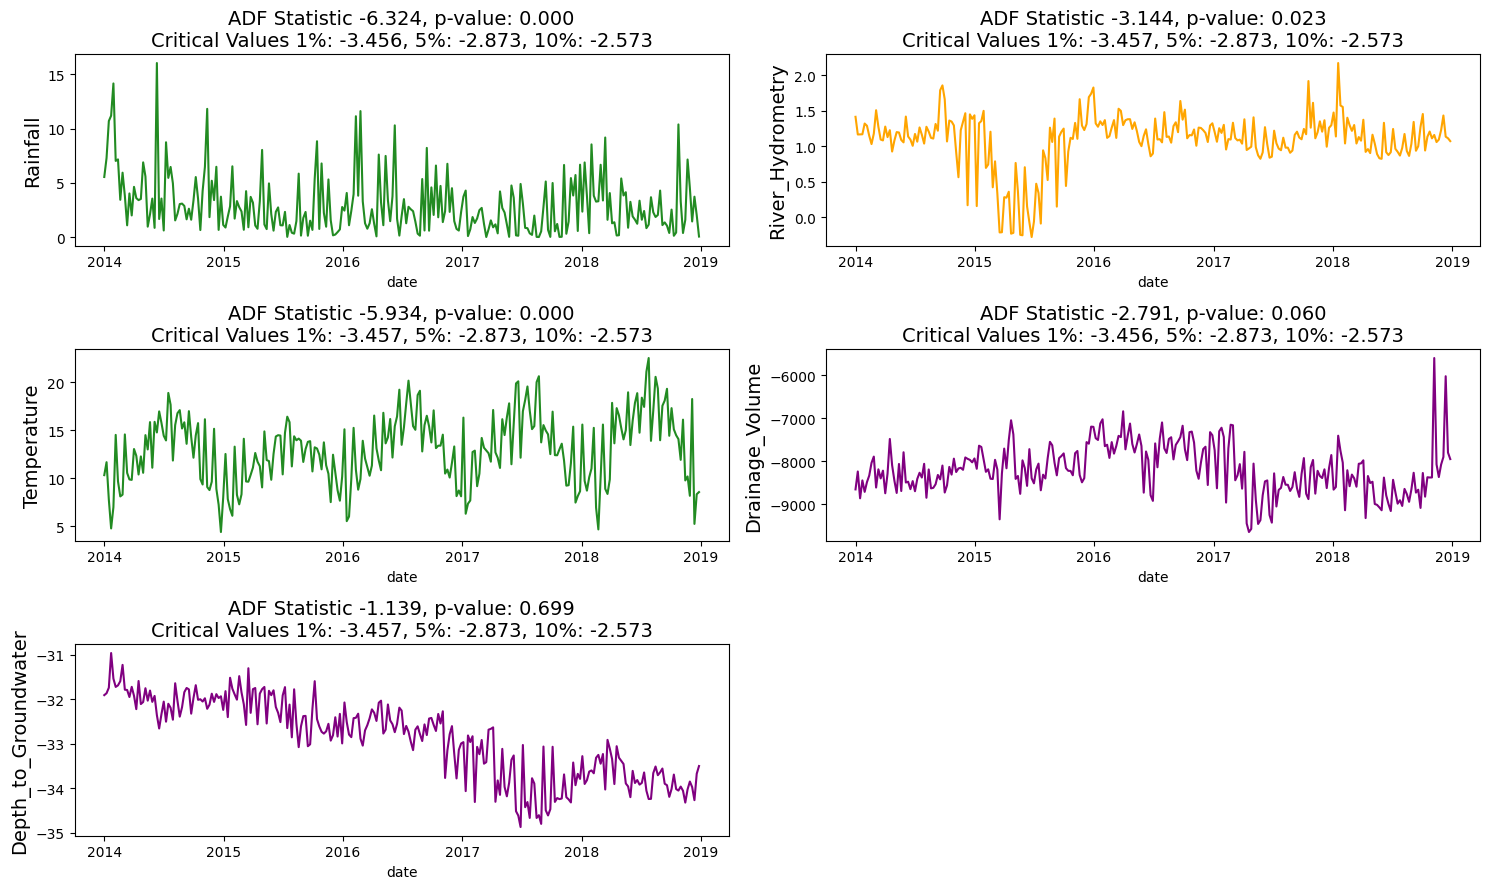

In [17]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* **Transformation**: e.g. log or square root to stabilize non-constant variance
* **Differencing**: subtracts the current value from the previous

#### Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

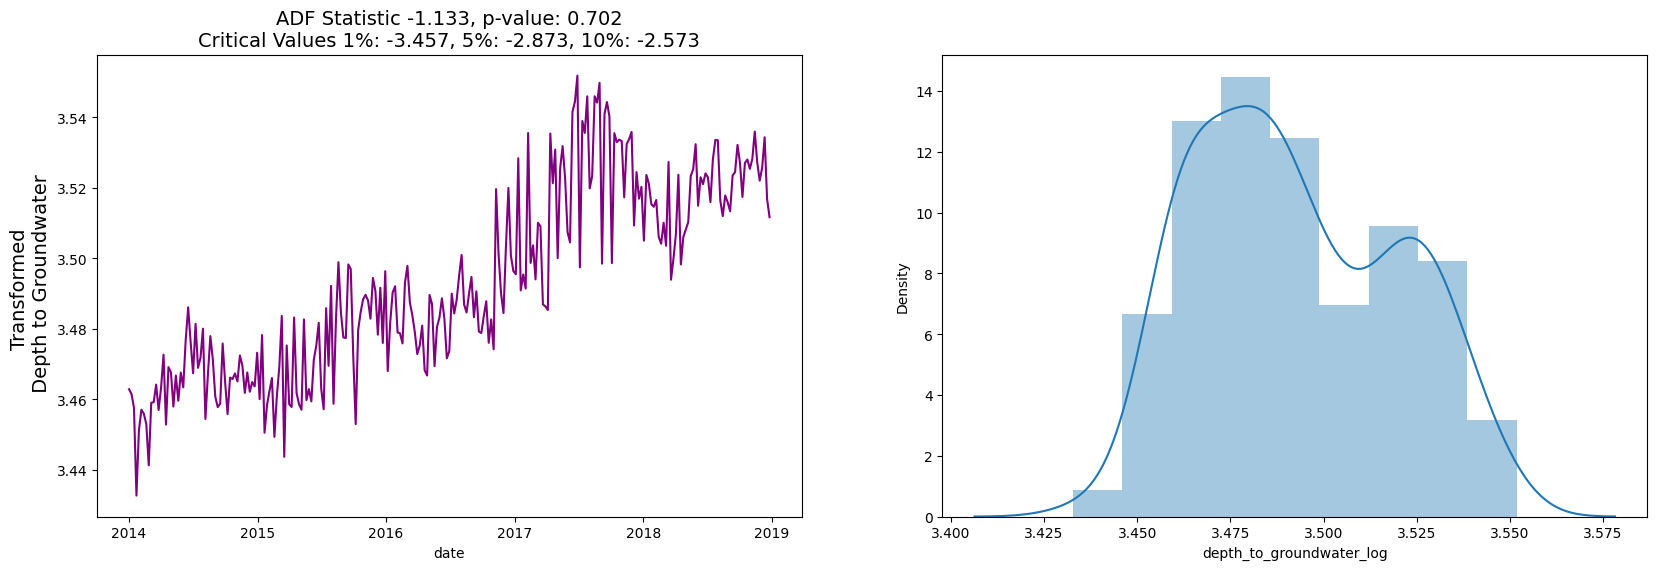

In [18]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing can be done in different orders:
* First order differencing: linear trends with $z_i = y_i - y_{i-1}$
* Second-order differencing: quadratic trends with $z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$
* and so on...

#### Differencing

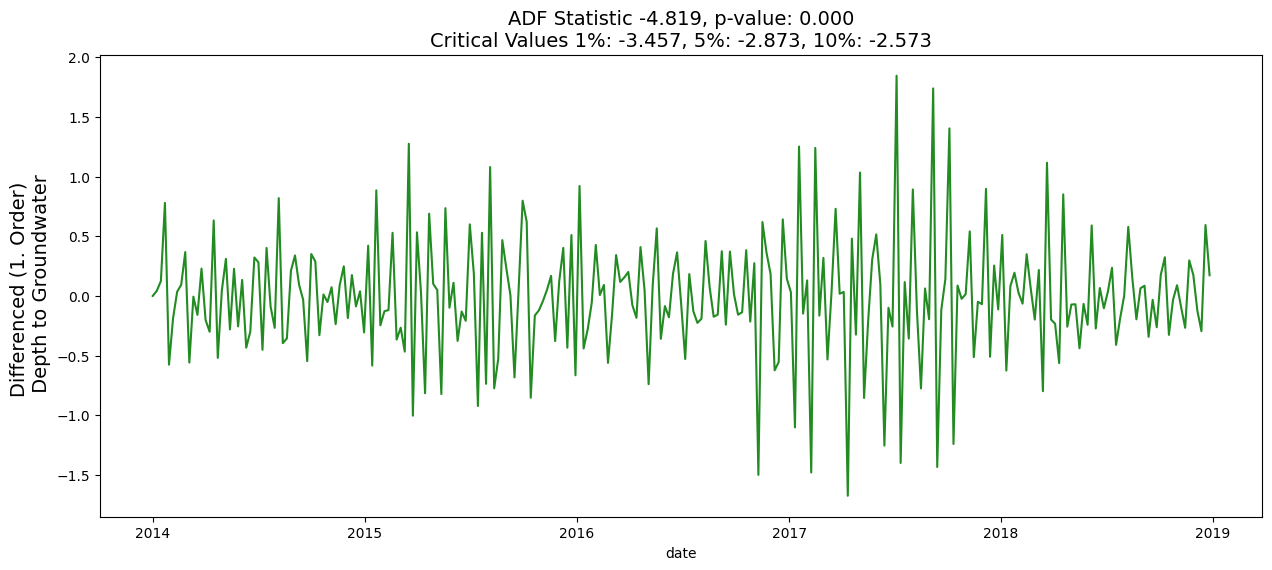

In [19]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

## Feature engineering

### TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use function STL() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [20]:
from statsmodels.tsa.seasonal import STL

core_columns = [
    'rainfall', 'temperature', 'drainage_volume',
    'river_hydrometry', 'depth_to_groundwater'
]

# STL decomposition and storing components
for column in core_columns:
    stl = STL(df[column], period=52, robust=True)
    result = stl.fit()
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_resid"] = result.resid  # store residuals if needed

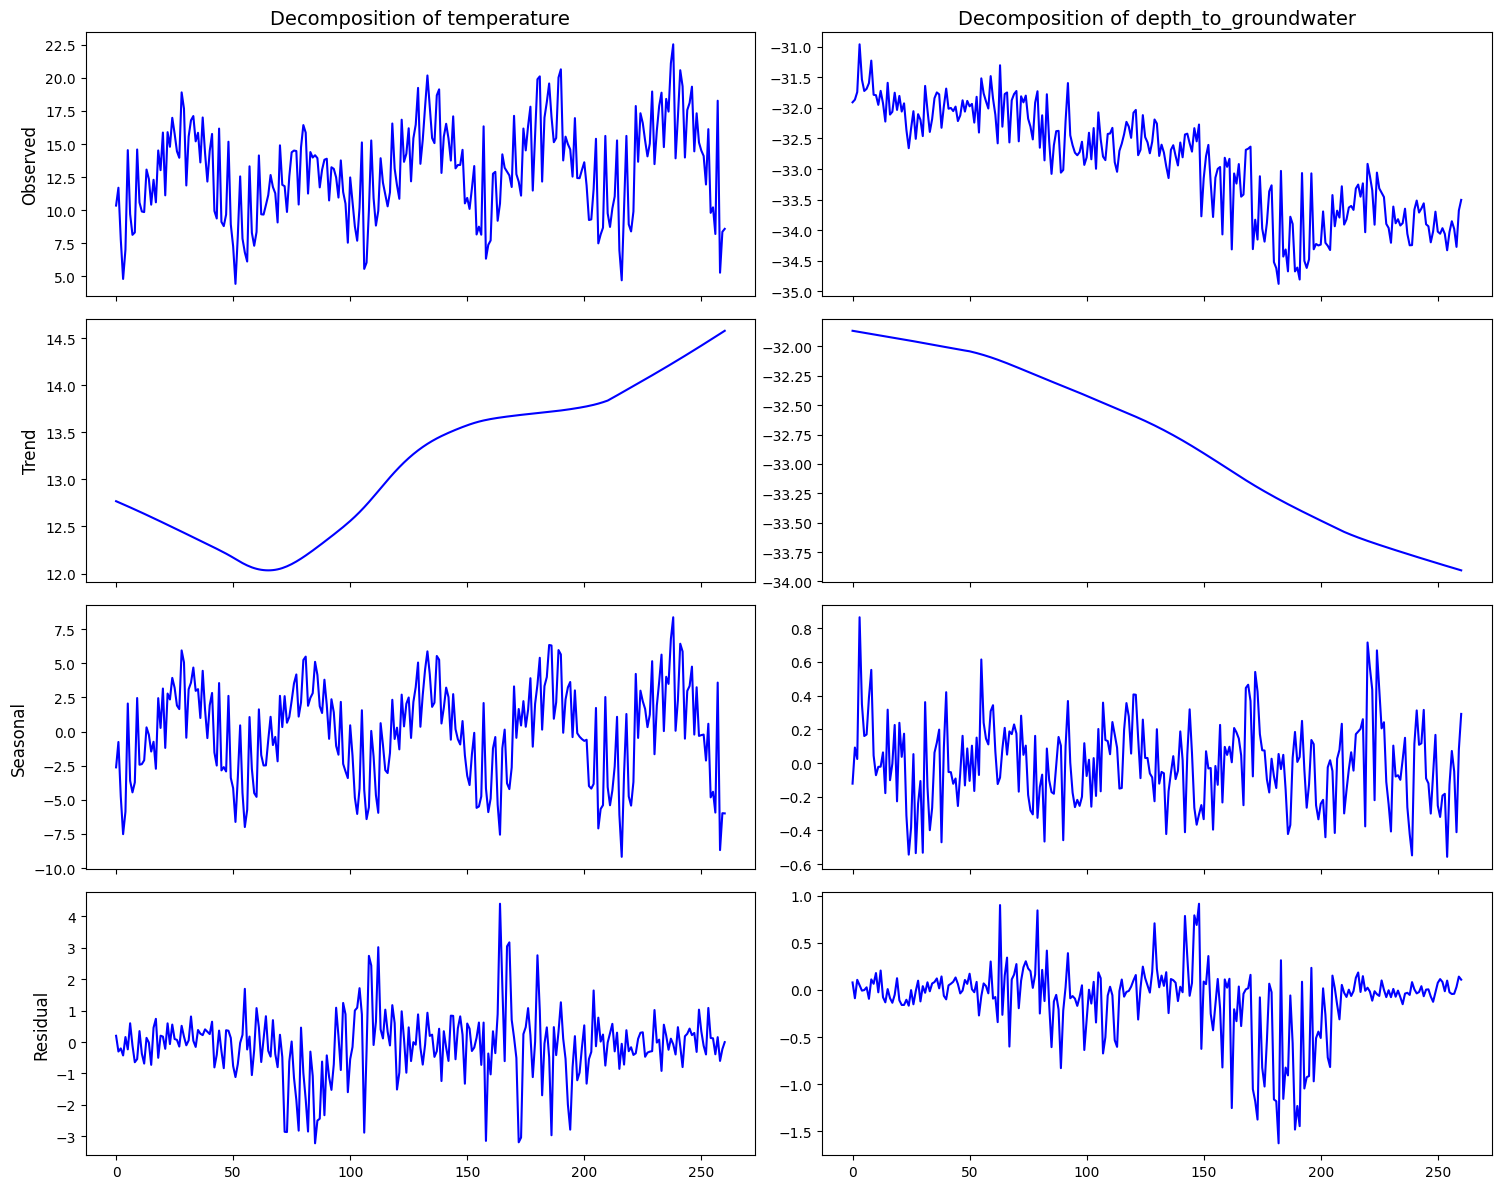

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12), sharex=True)

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    stl = STL(df[column], period=52, robust=True)
    res = stl.fit()

    ax[0, i].set_title(f'Decomposition of {column}', fontsize=14)
    res.observed.plot(ax=ax[0, i], legend=False, color='blue')
    if i == 0:
        ax[0, i].set_ylabel('Observed', fontsize=12)

    res.trend.plot(ax=ax[1, i], legend=False, color='blue')
    if i == 0:
        ax[1, i].set_ylabel('Trend', fontsize=12)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='blue')
    if i == 0:
        ax[2, i].set_ylabel('Seasonal', fontsize=12)

    res.resid.plot(ax=ax[3, i], legend=False, color='blue')
    if i == 0:
        ax[3, i].set_ylabel('Residual', fontsize=12)

plt.tight_layout()
plt.show()


### Lag


We want to calculate each variable with a `shift()` (lag) to compare the correlationwith the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [22]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## Exploratory Data Analysis

Now, we are going to plot the data and try to extract some knowledge.

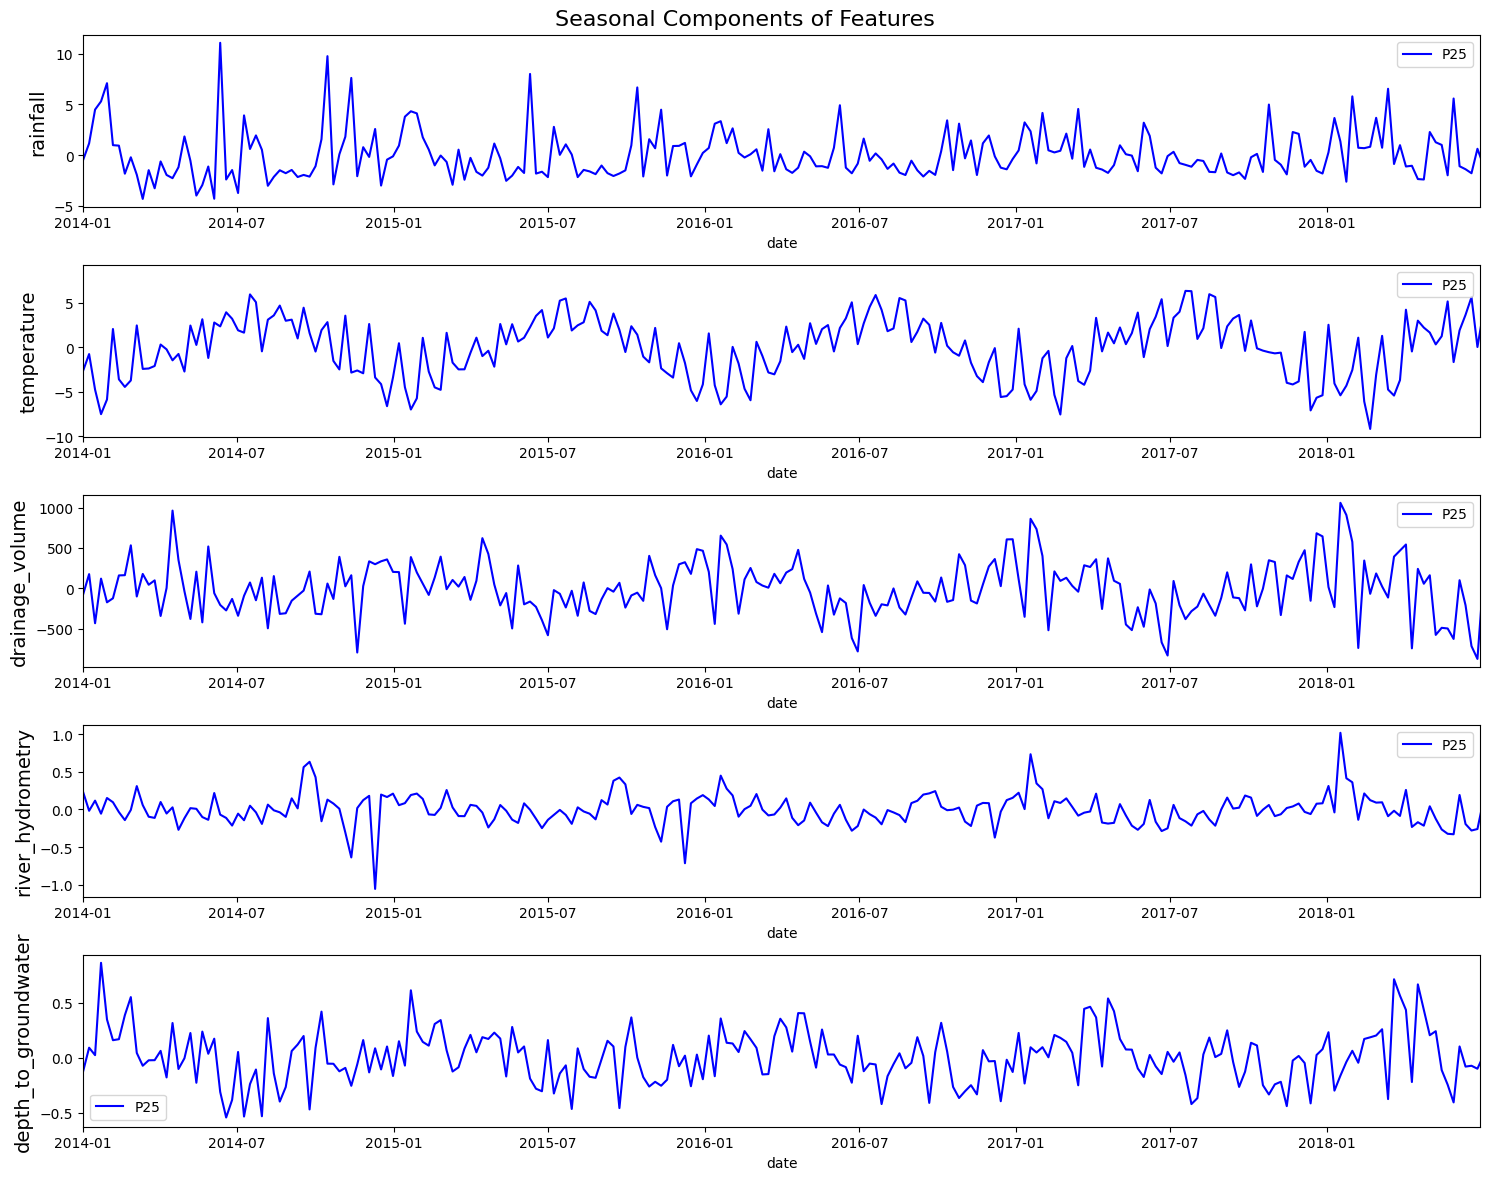

In [23]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='blue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim(between_dates)

plt.tight_layout()
plt.show()

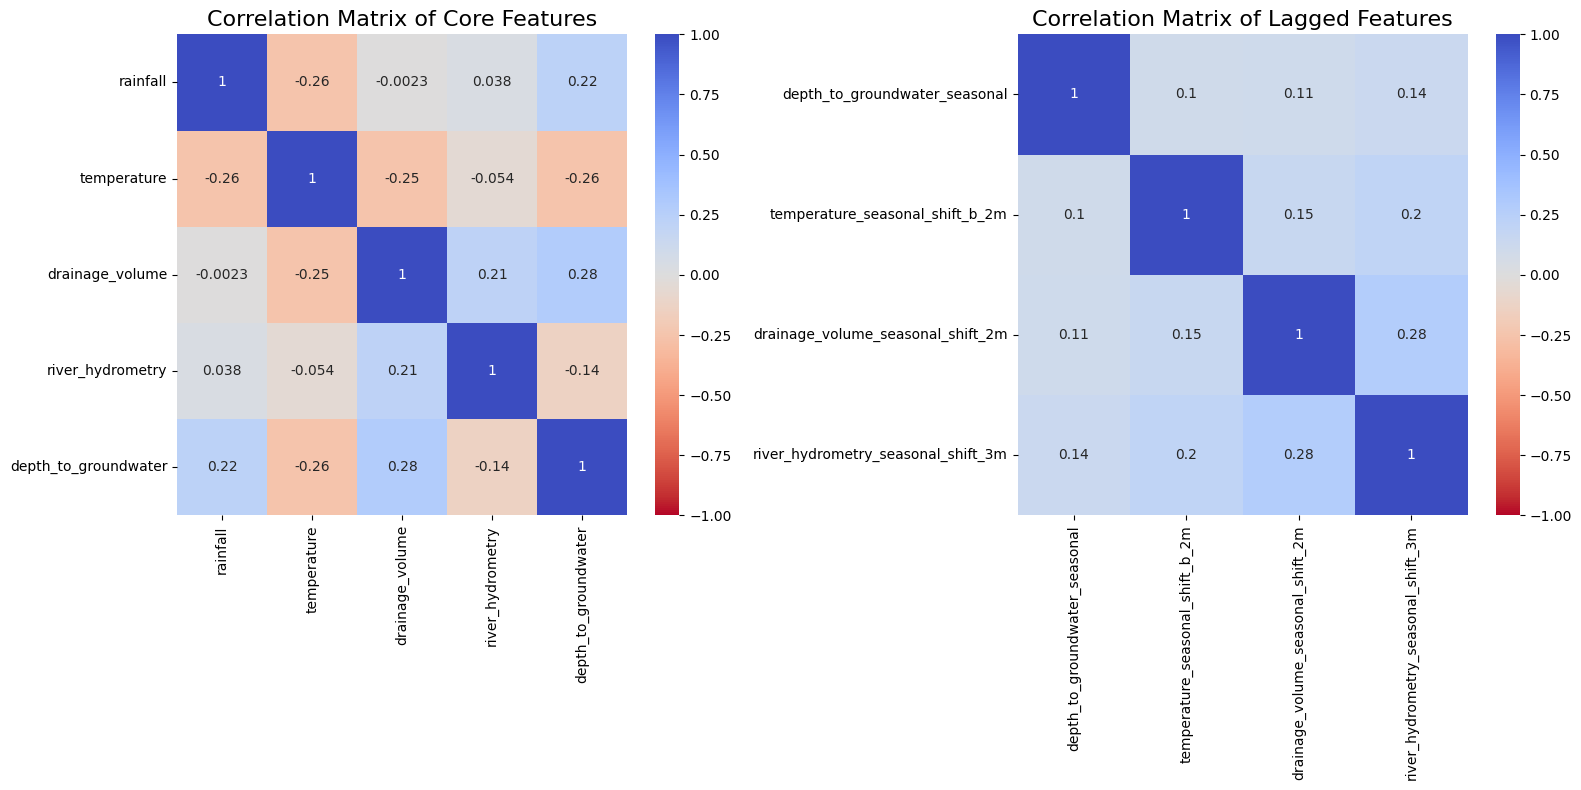

In [24]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m',
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

### Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

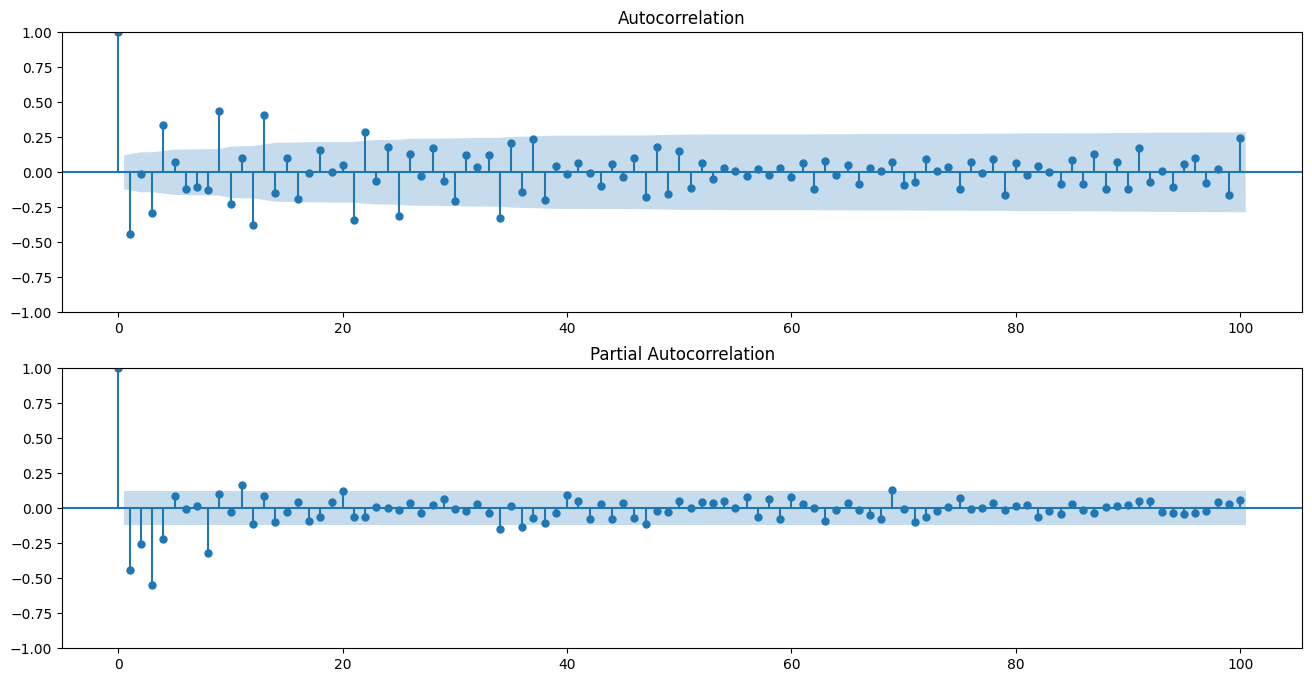

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

## Modeling

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

### Models for Univariate Time *Series*

First of all, we are going to analize univariate TimeSeries forecasting.

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [26]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

221 40


#### ARIMA

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>:
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (reference  PACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))
* <font color='orange'>d</font>: Degree of differencing. (reference  Differencing in [Stationarity](#2.3-Stationarity))
* <font color='blue'>q</font>: Order of moving average (check out ACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.

MAE: 0.46, RMSE: 0.52


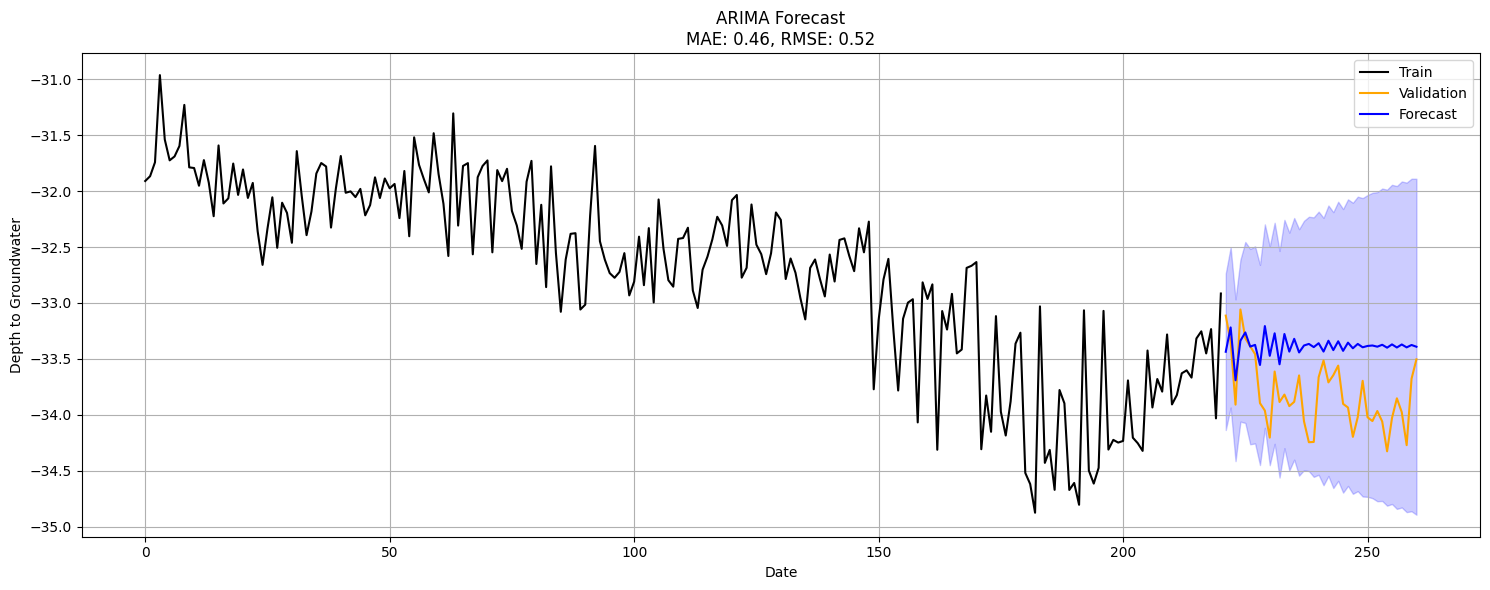

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Fit ARIMA model (you can tune the order)
model = ARIMA(y_train, order=(4, 1, 2))
model_fit = model.fit()

# Forecast
forecast_result = model_fit.get_forecast(steps=len(y_valid))
y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Evaluation metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
print(f'MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}')

# Plot: Forecast with confidence interval
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Train', color='black')
plt.plot(y_valid, label='Validation', color='orange')
plt.plot(y_pred, label='Forecast', color='blue')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.title(f'ARIMA Forecast\nMAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Models for Multivariate Time *Series*

#### Prophet

In [28]:
!pip install prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme6d828n/m83qkzoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpme6d828n/g9dm2uwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64985', 'data', 'file=/tmp/tmpme6d828n/m83qkzoq.json', 'init=/tmp/tmpme6d828n/g9dm2uwb.json', 'output', 'file=/tmp/tmpme6d828n/prophet_model5yo_385l/prophet_model-20250614163214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.35972773118569706
MAE: 0.28875932424887873


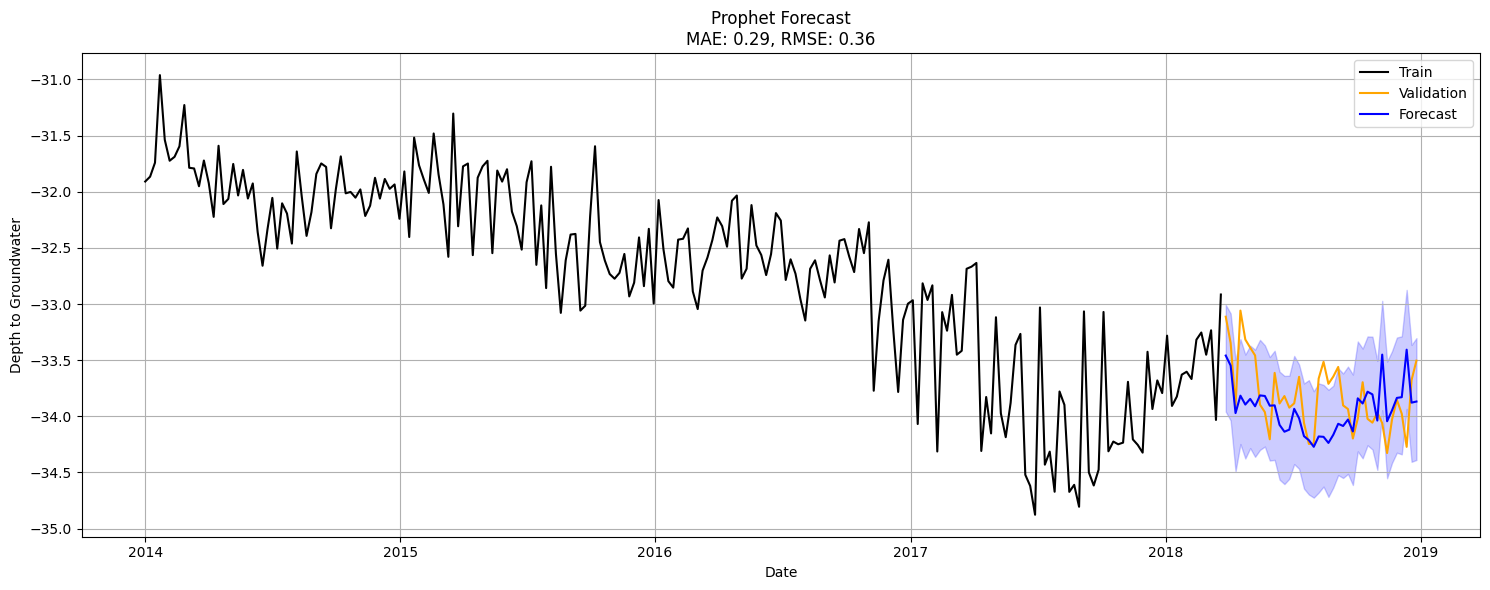

In [29]:
from prophet import Prophet

# Use the original dataframe with all features and rename columns
prophet_df = df.copy()
prophet_df = prophet_df[['date', 'depth_to_groundwater', 'rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']].copy()
prophet_df.rename(columns={'date': 'ds', 'depth_to_groundwater': 'y'}, inplace=True)

# Split the dataframe into train and validation sets
train_size = int(0.85 * len(prophet_df))
train_prophet = prophet_df.iloc[:train_size, :].copy()
valid_prophet = prophet_df.iloc[train_size:, :].copy() # Also need regressors for prediction

# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with the train set including regressors
model.fit(train_prophet)

# Predict on the valid set including regressors
y_pred = model.predict(valid_prophet[['ds', 'rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']])

# Calculate metrics
score_mae = mean_absolute_error(valid_prophet['y'], y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(valid_prophet['y'], y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.BLUE + 'MAE: {}'.format(score_mae))

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train', color='black')
plt.plot(valid_prophet['ds'], valid_prophet['y'], label='Validation', color='orange')
plt.plot(y_pred['ds'], y_pred['yhat'], label='Forecast', color='blue')
plt.fill_between(y_pred['ds'], y_pred['yhat_lower'], y_pred['yhat_upper'], color='blue', alpha=0.2)

plt.title(f'Prophet Forecast\nMAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()